In [22]:
#CODE: https://medium.com/nerd-for-tech/image-classification-using-transfer-learning-pytorch-resnet18-32b642148cbe

#CONFUSION MATRIX: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import albumentations as A
import random


device = torch.device("cpu")

In [71]:
transforms_train = transforms.Compose([     
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ColorJitter(brightness=random.uniform(0.0, 2.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.Resize((52, 310)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((52, 310)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [72]:
train_dir = '/Users/albert/Desktop/Final_Thesis/old_new_CvsEHPA_dataset/Train'
test_dir = '/Users/albert/Desktop/Final_Thesis/old_new_CvsEHPA_dataset/Test'
train_classa_dir = '/Users/albert/Desktop/Final_Thesis/old_new_CvsEHPA_dataset/Train/EH'
train_classb_dir = '/Users/albert/Desktop/Final_Thesis/old_new_CvsEHPA_dataset/Train/PA'
test_classa_dir = '/Users/albert/Desktop/Final_Thesis/old_new_CvsEHPA_dataset/Test/EH'
test_classb_dir = '/Users/albert/Desktop/Final_Thesis/old_new_CvsEHPA_dataset/Test/PA'

In [73]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [74]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 384
Test dataset size: 164
Class names: ['Controls', 'EH+PA']


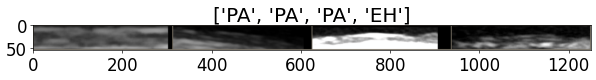

In [37]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [75]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
from sklearn.metrics import confusion_matrix

num_epochs = 20   #(set no of epochs)
loss_tr = []
acc_tr = []
sensit_tr = []
specif_tr = []
loss_tst = []
acc_tst = []
sensit_tst = []
specif_tst = []

start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("\nEpoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    y_pred_tr = []
    y_true_tr = []
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred_tr.extend(output) # Save Prediction
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        labels = labels.data.cpu().numpy()
        y_true_tr.extend(labels) # Save Truth

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
   
    #print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

    cf_matrix_tr = confusion_matrix(y_true_tr, y_pred_tr)
    TP_tr = cf_matrix_tr[0][0]
    TN_tr = cf_matrix_tr[1][1]
    FP_tr = cf_matrix_tr[0][1]
    FN_tr = cf_matrix_tr[1][0]
    sensitivity_tr = TP_tr / (TP_tr + FN_tr)
    specificity_tr = TN_tr / (TN_tr + FP_tr)
    

    """ Testing Phase """
    model.eval()
    y_pred_tst = []
    y_true_tst = []
    
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred_tst.extend(output) # Save Prediction
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            labels_2 = labels.data.cpu().numpy()
            y_true_tst.extend(labels_2) # Save Truth
        
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset)
    cf_matrix_tst = confusion_matrix(y_true_tst, y_pred_tst)
    print(cf_matrix_tst)
    TP_tst = cf_matrix_tst[0][0]
    TN_tst = cf_matrix_tst[1][1]
    FP_tst = cf_matrix_tst[0][1]
    FN_tst = cf_matrix_tst[1][0]
    sensitivity_tst = TP_tst / (TP_tst + FN_tst)
    specificity_tst = TN_tst / (TN_tst + FP_tst)
    print('\n[Test #{}] Loss: {:.4f} Acc: {:.4f}% Sens: {} Spec: {}'.format(epoch, epoch_loss, epoch_acc, sensitivity_tst, specificity_tst))




Epoch 0 running
[[54  3]
 [71 36]]

[Test #0] Loss: 0.6918 Acc: 0.5488% Sens: 0.432 Spec: 0.9230769230769231

Epoch 1 running
[[20 37]
 [14 93]]

[Test #1] Loss: 0.5746 Acc: 0.6890% Sens: 0.5882352941176471 Spec: 0.7153846153846154

Epoch 2 running
[[  4  53]
 [  1 106]]

[Test #2] Loss: 0.6016 Acc: 0.6707% Sens: 0.8 Spec: 0.6666666666666666

Epoch 3 running
[[  6  51]
 [  1 106]]

[Test #3] Loss: 0.6659 Acc: 0.6829% Sens: 0.8571428571428571 Spec: 0.6751592356687898

Epoch 4 running
[[ 17  40]
 [  6 101]]

[Test #4] Loss: 0.5967 Acc: 0.7195% Sens: 0.7391304347826086 Spec: 0.7163120567375887

Epoch 5 running
[[20 37]
 [ 8 99]]

[Test #5] Loss: 0.6079 Acc: 0.7256% Sens: 0.7142857142857143 Spec: 0.7279411764705882

Epoch 6 running
[[ 18  39]
 [  7 100]]

[Test #6] Loss: 0.6721 Acc: 0.7195% Sens: 0.72 Spec: 0.7194244604316546

Epoch 7 running
[[28 29]
 [13 94]]

[Test #7] Loss: 0.6866 Acc: 0.7439% Sens: 0.6829268292682927 Spec: 0.7642276422764228

Epoch 8 running
[[22 35]
 [ 9 98]]

[Test

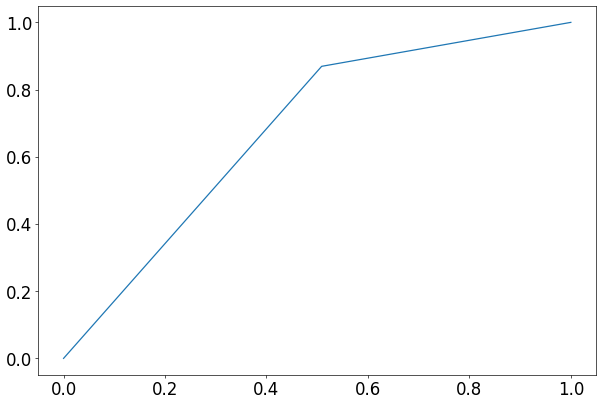

In [77]:
from torchmetrics import ROC, AUC

roc = ROC(task="binary")
pred = torch.FloatTensor(y_pred_tst)
true = torch.FloatTensor(y_true_tst)

fpr, tpr, _ = roc(pred, true)
plt.plot(fpr, tpr)
plt.savefig("ROC Curve Augment")

In [ ]:
    if(epoch%2==0):
        loss_tst.append('(' + str(epoch)+ ',' + str(epoch_loss) + ')')
        acc_tst.append('(' + str(epoch)+ ',' + str(epoch_acc.item()) + ')')
        sensit_tst.append('(' + str(epoch)+ ',' + str(sensitivity_tst) + ')')
        specif_tst.append('(' + str(epoch)+ ',' + str(specificity_tst) + ')')
    elif(epoch==0):
        loss_tst.append('(' + str(epoch)+ ',' + str(epoch_loss) + ')')
        acc_tst.append('(' + str(epoch)+ ',' + str(epoch_acc.item()) + ')')
        sensit_tst.append('(' + str(epoch)+ ',' + str(sensitivity_tst) + ')')
        specif_tst.append('(' + str(epoch)+ ',' + str(specificity_tst) + ')')


    

In [23]:
with open("../Results/New_EHvsPA_lr0.0001_aug.txt","w") as file:
            file.write("Results trainset: \n")
            file.write("Loss: \n")
            file.write(str(loss_tr))
            file.write("\nAccuracy: \n")
            file.write(str(acc_tr))
            file.write("\nSensitivity: \n")
            file.write(str(sensit_tr))
            file.write("\nSpecificity: \n")
            file.write(str(specif_tr))
            file.write("\n\nResults testset: \n")
            file.write("Loss: \n")
            file.write(str(loss_tst))
            file.write("\nAccuracy: \n")
            file.write(str(acc_tst))
            file.write("\nSensitivity: \n")
            file.write(str(sensit_tst))
            file.write("\nSpecificity: \n")
            file.write(str(specif_tst))